In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import seaborn as sns
import re
from convex_optimization_deriving_results import Example_Anaheim, Network, Investors, Consumers, Example, Example_6node
from Transportaion_test_systems import import_matrix, transportation_network_topo
import math

In [22]:
def getNumbers(str):
    array = re.findall(r'[0-9]+', str)
    return array

### Adding results paths

In [23]:
root = (os.getcwd())
results_path = root + '/Results'
directory_contents = sorted(os.listdir(results_path))
results_folders=[]
# for item in directory_contents:
#     if os.path.isdir(item):
# #         print(getNumbers(item))
#         results_folders.append(item)
        
final_results_path = os.path.join(results_path, directory_contents[-1])
determenistic_result_directory = os.path.dirname(os.getcwd()) + '/script_v8_deterministic_speed_up'

In [24]:
directory_contents

['.ipynb_checkpoints',
 'Resulting_exsu.csv',
 'Resulting_prices.csv',
 'Resulting_scendiff.csv',
 'Results_20211024_1741',
 'Results_20211109_1026',
 'Results_20211112_1632',
 'Results_20211112_1919',
 'Results_20211112_2022',
 'Results_20211112_2302']

In [25]:
final_results_path

'/home/sinabaghali/Git/2018_stochastic_fast_charging/code/script_v7_stochastic_speed_up/Results/Results_20211112_2302'

### Figures setup

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (9, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['lines.linewidth'] = 2
 
mpl.rc('font',family='Times New Roman', size=18)
fnt_size=30
fnt_size2=20
csfont = {'fontname':'Times New Roman',
                  'size': fnt_size,
                 'fontweight':'bold'}
csfont2 = {'fontname':'Times New Roman',
                  'size': fnt_size2}

### Helper functions for reading results

In [27]:
def data_reader(file_name, result_type):
    
    
    scenarios = []
    nodes = []
    value = []
    value_dict={}
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            while("" in row):
                row.remove("")
#         row_numbers = getNumbers(row)
            scenarios.append(int(getNumbers(row[0])[0]))
            nodes.append(int(getNumbers(row[1])[0]))
            value.append(float(row[-1]))
            if result_type == 'stochastic':
                value_dict[int(getNumbers(row[1])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
            elif result_type == 'deterministic':
                value_dict[int(getNumbers(row[1])[0])] = float(row[-1])
            
    value_stochastic_dict= {'Nodes':nodes, 'Scenarios':scenarios, 'Values':value}
    value_stochastic_df = pd.DataFrame(value_stochastic_dict)
            
    return value_stochastic_df, value_dict

def traffic_data_reader(file_name, traffic_type):
    
    if traffic_type == 'q':
        q={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                q[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return q
    
    elif traffic_type == 'x':
        x={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                x[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[5])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return x
    
    elif traffic_type == 'lamda':
        lamda={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                lamda[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[3])[0]), int(getNumbers(row[4])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return lamda
    elif traffic_type == 'mu':
        mu={}
        with open(file_name, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                while("" in row):
                    row.remove("")
                mu[int(getNumbers(row[1])[0]), int(getNumbers(row[2])[0]), int(getNumbers(row[0])[0])] = float(row[-1])
        return mu
    
    else:
        print('Invalid traffic type; valid options are: q, x, lamda, mu')

# Prices

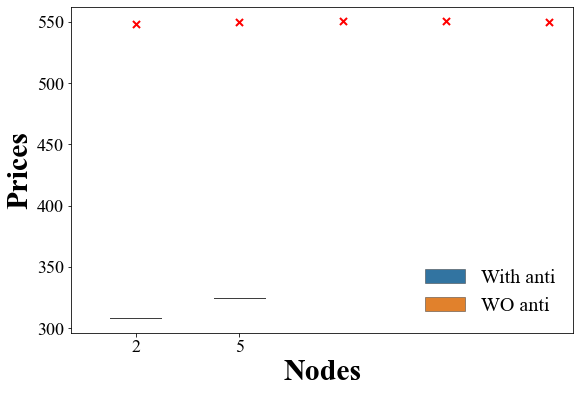

In [28]:
price_file_stochastic = os.path.join(final_results_path, 'Resulting_prices_with_anti.csv')
price_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_prices_with_no_anti.csv')
price_file_deterministic = os.path.join(determenistic_result_directory, 'Results_prices.csv')


prices_stochastic_df, rho_stochastic = data_reader(file_name=price_file_stochastic,result_type='stochastic')

prices_stochastic_wo_anti_df, rho_stochastic_wo_anti = data_reader(file_name=price_file_stochastic_wo_anti,result_type='stochastic')

combined_prices_df = pd.DataFrame()
combined_prices_df['Nodes'] = list(prices_stochastic_df.Nodes) + list(prices_stochastic_wo_anti_df.Nodes)
combined_prices_df['Scenarios'] = list(prices_stochastic_df.Scenarios) + list(prices_stochastic_wo_anti_df.Scenarios)
combined_prices_df['Values'] = list(prices_stochastic_df.Values) + list(prices_stochastic_wo_anti_df.Values)
combined_prices_df['Types'] = ['With anti']*len(prices_stochastic_df.Nodes) + ['WO anti']*len(prices_stochastic_wo_anti_df.Nodes)


prices_deterministic_df, rho_deterministic = data_reader(file_name=price_file_deterministic,result_type='deterministic')

fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_prices_df, hue='Types', linewidth=1, width=0.5)
ax.scatter(range(len(prices_deterministic_df.Nodes)),prices_deterministic_df.Values, marker='x', color='red', s=50)
ax.set_xlabel("Nodes",**csfont)
ax.set_ylabel("Prices",**csfont);
legend = plt.legend(fontsize=20, frameon=False);
# legend = plt.legend(loc='best', bbox_to_anchor=(0.6, 0.5, 0, 0) ,ncol=2, title='Nodes',fontsize=20, frameon=False)

In [29]:
combined_prices_df

,Nodes,Scenarios,Values,Types
0,2,1,308.214983,With anti
1,5,1,324.644948,With anti
2,2,1,308.214983,WO anti
3,5,1,324.644948,WO anti


# Services (g)

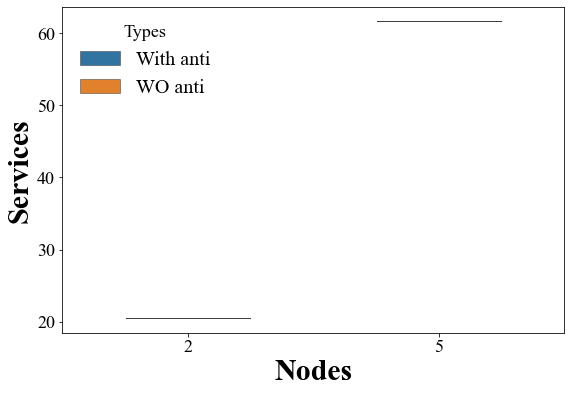

In [30]:
service_file_stochastic = os.path.join(final_results_path, 'Resulting_services_with_anti.csv')
service_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_services_with_no_anti.csv')
service_file_deterministic = os.path.join(determenistic_result_directory, 'Results_services.csv')


services_df_stochastic, g_stochastic = data_reader(file_name=service_file_stochastic,result_type='stochastic')
services_df_stochastic_wo_anti, g_stochastic_wo_anti = data_reader(file_name=service_file_stochastic_wo_anti,result_type='stochastic')
combined_services_df = pd.DataFrame()
combined_services_df['Nodes'] = list(services_df_stochastic.Nodes) + list(services_df_stochastic_wo_anti.Nodes)
combined_services_df['Scenarios'] = list(services_df_stochastic.Scenarios) + list(services_df_stochastic_wo_anti.Scenarios)
combined_services_df['Values'] = list(services_df_stochastic.Values) + list(services_df_stochastic_wo_anti.Values)
combined_services_df['Types'] = ['With anti']*len(services_df_stochastic.Nodes) + ['WO anti']*len(services_df_stochastic_wo_anti.Nodes)

services_df_deterministic, g_deterministic = data_reader(file_name=service_file_deterministic,result_type='deterministic') 

fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_services_df, hue='Types', linewidth=1, width=0.5)
# ax.scatter(range(len(services_df_deterministic.Nodes)), services_df_deterministic.Values, color='red', marker ='x', s=50)
# ax.set_ylim(480,800)
ax.set_xlabel("Nodes",**csfont)
ax.set_ylabel("Services",**csfont);
legend = plt.legend(loc='upper left',  title='Types',fontsize=20, frameon=False);

# Capacity

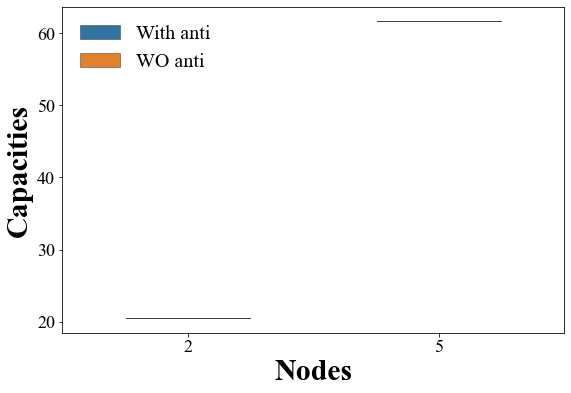

In [31]:
capacities_file_stochastic = os.path.join(final_results_path, 'Resulting_capacities_with_anti.csv')
capacities_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_capacities_with_no_anti.csv')
capacity_file_deterministic = os.path.join(determenistic_result_directory, 'Results_capacity.csv')

capacity_df_stochastic, c_stochastic = data_reader(file_name=capacities_file_stochastic,result_type='stochastic')
capacity_df_stochastic_wo_anti, c_stochastic_wo_anti = data_reader(file_name=capacities_file_stochastic_wo_anti,result_type='stochastic')
combined_capacity_df = pd.DataFrame()
combined_capacity_df['Nodes'] = list(capacity_df_stochastic.Nodes) + list(capacity_df_stochastic_wo_anti.Nodes)
combined_capacity_df['Scenarios'] = list(capacity_df_stochastic.Scenarios) + list(capacity_df_stochastic_wo_anti.Scenarios)
combined_capacity_df['Values'] = list(capacity_df_stochastic.Values) + list(capacity_df_stochastic_wo_anti.Values)
combined_capacity_df['Types'] = ['With anti']*len(capacity_df_stochastic.Nodes) + ['WO anti']*len(capacity_df_stochastic_wo_anti.Nodes)


capacity_df_deterministic, c_deterministic = data_reader(file_name=capacity_file_deterministic,result_type='deterministic')


fig, ax = plt.subplots()
ax = sns.boxplot(x='Nodes', y='Values', data=combined_capacity_df, hue= 'Types', linewidth=1, width=0.5)
# ax.scatter(range(len(capacity_df_deterministic.Nodes)), capacity_df_deterministic.Values, color='red', marker ='x', s=50)
ax.set_xlabel("Nodes",**csfont)
ax.set_ylabel("Capacities",**csfont);
legend = plt.legend(fontsize=20, frameon=False);

# Traffic

In [32]:
Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_traffic_with_anti.csv')
Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_traffic_with_no_anti.csv')
Traffic_file_deterministic = os.path.join(determenistic_result_directory, 'Results_traffic.csv')

q_stochastic = traffic_data_reader(Traffic_file_stochastic,'q')
q_stochastic_wo_anti = traffic_data_reader(Traffic_file_stochastic_wo_anti,'q')
q_deterministic = traffic_data_reader(Traffic_file_deterministic,'q')

Link_Traffic_file_stochastic = os.path.join(final_results_path, 'Resulting_link_traffic_with_anti.csv')
Link_Traffic_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_link_traffic_with_no_anti.csv')

x_stochastic = traffic_data_reader(Link_Traffic_file_stochastic, 'x')
x_stochastic_wo_anti = traffic_data_reader(Link_Traffic_file_stochastic_wo_anti, 'x')

lamda1_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda1_with_anti.csv')
lamda1_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda1_with_no_anti.csv')

lamda1_stochastic = traffic_data_reader(lamda1_file_stochastic, 'lamda')
lamda1_stochastic_wo_anti = traffic_data_reader(lamda1_file_stochastic, 'lamda')

lamda2_file_stochastic = os.path.join(final_results_path, 'Resulting_lamda2_with_anti.csv')
lamda2_file_stochastic_wo_anti = os.path.join(final_results_path, 'Resulting_lamda2_with_no_anti.csv')

lamda2_stochastic = traffic_data_reader(lamda2_file_stochastic, 'lamda')
lamda2_stochastic_wo_anti = traffic_data_reader(lamda2_file_stochastic, 'lamda')

mu_stochastic = traffic_data_reader(lamda2_file_stochastic, 'mu')
mu_stochastic_wo_anti = traffic_data_reader(lamda2_file_stochastic, 'mu')

# Surpluss analysis

### Loading network parameters

In [33]:
congestion = False 
identical_scen = False 
Ntw = Example_6node(identical_scen, congestion)


growth at scen  1 :  1.0268728488224803


### Investors cost calculation

In [34]:
Investors_total_cost = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) +
    (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_total_cost_wo_anti = sum (Ntw.Scn.pr[u] *(
    (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) +
    (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors costs       With non-anti      WO non-anti')
print('                     ', round(Investors_total_cost,4), '     ', round(Investors_total_cost_wo_anti,4))

Investors costs       With non-anti      WO non-anti
                      25488.5227       25488.5227


### Investors objective calculation

In [35]:
Investors_objective = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic[k,u]*g_stochastic[k,u] -
        (Ntw.I.ca*c_stochastic[k,u]**2 + Ntw.I.cb*c_stochastic[k,u]) - 
        (Ntw.I.ga*g_stochastic[k,u]**2+Ntw.I.gb*g_stochastic[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)

Investors_objective_wo_anti = sum(Ntw.Scn.pr[u] *( 
    rho_stochastic_wo_anti[k,u]*g_stochastic_wo_anti[k,u] -
        (Ntw.I.ca*c_stochastic_wo_anti[k,u]**2 + Ntw.I.cb*c_stochastic_wo_anti[k,u]) - 
        (Ntw.I.ga*g_stochastic_wo_anti[k,u]**2+Ntw.I.gb*g_stochastic_wo_anti[k,u])) for k in Ntw.I.K for u in Ntw.Scn.U)
print('Investors Obj       With non-anti      WO non-anti')
print('                   ', round(Investors_objective,5), '     ', round(Investors_objective_wo_anti,4))

Investors Obj       With non-anti      WO non-anti
                    843.57426       843.5743


In [36]:
Ntw.Scn.pr


{1: 1.0}

### Calculating utility and ravel time based on x

In [43]:
def travel_time(Ntw,lamda1,lamda2,mu):
    t={}
    A={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    A[r,s,k,u] = -lamda1[r,s,k,k,u] + lamda1[r,s,k,r,u] - lamda2[r,s,k,s,u] + lamda2[r,s,k,k,u]
                    t[r,s,k,u] = A[r,s,k,u]
#                     t[r,s,k,u] = (Ntw.C.b3/Ntw.Scn.pr[u]) * (A[r,s,k,u]- mu[r,s,u])
#                     t[r,s,k,u] = sum(Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((x[i,j,r,s,k,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
                    
    return t

def Utility_func(Ntw,lamda1,lamda2,mu,q,rho):
    t_time = travel_time(Ntw,lamda1,lamda2,mu)
    U={}
    for r in Ntw.C.R:
        for s in Ntw.C.S:
            for k in Ntw.C.K:
                for u in Ntw.Scn.U:
                    U[r,s,k,u] = Ntw.C.b0[k] - Ntw.C.b1 * t_time[r,s,k,u]- Ntw.C.b3*rho[k,u] * Ntw.C.e[r,s]
                    
                    
    return U

In [44]:
travel_time(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic)

{(1, 3, 2, 1): 15.768214,
 (1, 3, 5, 1): 15.404401,
 (1, 6, 2, 1): 22.501423,
 (1, 6, 5, 1): 23.194232,
 (4, 3, 2, 1): 22.989970999999993,
 (4, 3, 5, 1): 22.887598,
 (4, 6, 2, 1): 15.429866000000002,
 (4, 6, 5, 1): 15.356392}

In [19]:
Utility_stochastic = Utility_func(Ntw,lamda1_stochastic,lamda2_stochastic,mu_stochastic,q_stochastic,rho_stochastic)
Utility_stochastic_wo_anti = Utility_func(Ntw,lamda1_stochastic_wo_anti,lamda2_stochastic_wo_anti,mu_stochastic_wo_anti,q_stochastic_wo_anti,rho_stochastic_wo_anti)



In [20]:
lamda1_stochastic

{(1, 3, 2, 1, 1): 7.943939,
 (1, 3, 2, 2, 1): -0.056061,
 (1, 3, 2, 3, 1): -7.719697,
 (1, 3, 2, 4, 1): 7.271212,
 (1, 3, 2, 5, 1): -0.056061,
 (1, 3, 2, 6, 1): -7.383333,
 (1, 3, 5, 1, 1): 14.030077,
 (1, 3, 5, 2, 1): 6.25699,
 (1, 3, 5, 3, 1): -1.29319,
 (1, 3, 5, 4, 1): -5.131477,
 (1, 3, 5, 5, 1): -12.625433,
 (1, 3, 5, 6, 1): -1.236967,
 (1, 6, 2, 1, 1): 8.014015,
 (1, 6, 2, 2, 1): 0.014015,
 (1, 6, 2, 3, 1): -7.313258,
 (1, 6, 2, 4, 1): 7.173106,
 (1, 6, 2, 5, 1): -0.238258,
 (1, 6, 2, 6, 1): -7.649621,
 (1, 6, 5, 1, 1): 20.343918,
 (1, 6, 5, 2, 1): 12.569499,
 (1, 6, 5, 3, 1): 5.242226,
 (1, 6, 5, 4, 1): -17.711594,
 (1, 6, 5, 5, 1): -25.317744,
 (1, 6, 5, 6, 1): 4.873696,
 (4, 3, 2, 1, 1): 7.131104,
 (4, 3, 2, 2, 1): -0.196168,
 (4, 3, 2, 3, 1): -7.859805,
 (4, 3, 2, 4, 1): 7.803832,
 (4, 3, 2, 5, 1): 0.308377,
 (4, 3, 2, 6, 1): -7.187078,
 (4, 3, 5, 1, 1): 7.275952,
 (4, 3, 5, 2, 1): -0.051321,
 (4, 3, 5, 3, 1): -7.602167,
 (4, 3, 5, 4, 1): 7.5885,
 (4, 3, 5, 5, 1): -0.051321,

### Surpluss calculation

In [20]:
Surpluss_stochastic = Investors_objective + sum (Utility_stochastic[r,s,k,u] * q_stochastic[r,s,k,u] for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

Surpluss_stochastic_wo_anti = Investors_total_cost_wo_anti + Investors_objective_wo_anti + sum (Utility_stochastic_wo_anti[r,s,k,u] * q_stochastic_wo_anti[r,s,k,u] for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K for u in Ntw.C.Scn.U)

print('Surpluss       With non-anti      WO non-anti')
print('              ', round(Surpluss_stochastic,4), '     ', round(Surpluss_stochastic_wo_anti,4))

Surpluss       With non-anti      WO non-anti
               323576.4349       1470265.4651


# EVPI analysis

## Investors

In [21]:
EVPI_investors = Investors_objective - Investors_objective_wo_anti
EVPI_investors

12465.467346251768

## Consumers 

In [22]:
def consumer_obj_func(Ntw,q,x,rho,c):
    v = {}
    for (r,s) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[r,s,u] = sum (x[r,s,i,j,k,u] for i in Ntw.C.R for j in Ntw.C.S for k in Ntw.C.K)
    
    exp0 = {}
    exp1 = {}
    for u in Ntw.Scn.U:
        exp0[u] = sum(Ntw.C.tff[r,s]*(v[r,s,u]+(Ntw.C.b[r,s]/(Ntw.C.alpha[r,s]+1.0))*(v[r,s,u]**(Ntw.C.alpha[r,s]+1))/(Ntw.C.cap[r,s]**(Ntw.C.alpha[r,s]))) for (r,s) in Ntw.C.A)
        exp1[u] = 1.0/Ntw.C.b1*( sum( q[r,s,k,u]*( math.log(q[r,s,k,u]) - 1.0 + Ntw.C.b3 * rho[k,u] * Ntw.C.e[r,s] - Ntw.C.b0[k]) for k in Ntw.C.K for s in Ntw.C.S for r in Ntw.C.R))
        
    consumer_obj = sum(exp0[u] + exp1[u] for u in Ntw.Scn.U) 
    
    return consumer_obj


In [23]:
Consumers_objective = consumer_obj_func(Ntw,q_stochastic,x_stochastic,rho_stochastic,c_stochastic)
Consumers_objective_wo_anti = consumer_obj_func(Ntw,q_stochastic_wo_anti,
                                                x_stochastic_wo_anti,
                                                rho_stochastic_wo_anti,
                                                c_stochastic_wo_anti)

EVPI_consumers = Consumers_objective_wo_anti - Consumers_objective
EVPI_consumers

1262521.2017279863

# Total travel time comparison

In [24]:
def total_travel_time(Ntw, x):
    v = {}
    for (i,j) in Ntw.C.A:
        for u in Ntw.Scn.U:
            v[i,j,u] = sum (x[i,j,r,s,k,u] for r in Ntw.C.R for s in Ntw.C.S for k in Ntw.C.K)
            
    tt_time = sum(v[i,j,u] * Ntw.C.tff[i,j] * (1+Ntw.C.b[i,j]*((v[i,j,u]/Ntw.C.cap[i,j])**Ntw.C.alpha[i,j])) for (i,j) in Ntw.C.A)
    
    return tt_time

In [25]:
tt_time = total_travel_time(Ntw, x_stochastic)
tt_time_wo_anti = total_travel_time(Ntw, x_stochastic_wo_anti)

print('Total travel time       With non-anti      WO non-anti')
print('                       ', round(tt_time,4), '       ', round(tt_time_wo_anti,4))

Total travel time       With non-anti      WO non-anti
                        139720.8195         139725.1935
